In [1]:
import cv2
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing

iam_input_root   = "/kaggle/input/iam-handwritten-forms-dataset/data"
iam_output_folder    = "dataset/handwritten_processed"
os.makedirs(iam_output_folder, exist_ok=True)

TARGET_SIZE = 224 * 2  # 448×448 for better resolution
NUM_WORKERS = min(8, multiprocessing.cpu_count())

In [2]:
def apply_threshold(image):
    """Otsu's binarization for optimal thresholding"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

def extract_handwritten_region(image_path):
    """Extract handwriting between 2nd and 3rd horizontal lines"""
    image = cv2.imread(image_path)
    if image is None:
        return None

    binary = apply_threshold(image)
    
    # Detect horizontal lines
    thresh_inv = 255 - binary
    kernel = np.ones((1, 50), np.uint8)
    black_lines = cv2.morphologyEx(thresh_inv, cv2.MORPH_OPEN, kernel, iterations=2)
    
    contours, _ = cv2.findContours(black_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) < 2:
        return None
    
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1])
    _, y2, _, h2 = cv2.boundingRect(contours[1])
    
    if len(contours) >= 3:
        _, y3, _, _ = cv2.boundingRect(contours[2])
        return binary[y2 + h2:y3, :]
    
    return binary[y2 + h2:, :]

def crop_and_resize(image):
    """Tight crop + resize in single operation"""
    binary_inv = 255 - image
    h, w = image.shape
    threshold = int(w * 0.02)
    
    # Vectorized row/column sums (much faster than loops)
    row_sums = np.sum(binary_inv > 0, axis=1)
    text_rows = np.where(row_sums > threshold)[0]
    
    if len(text_rows) == 0:
        return cv2.resize(image, (TARGET_SIZE, TARGET_SIZE))
    
    first_row, last_row = text_rows[0], text_rows[-1]
    
    col_sums = np.sum(binary_inv > 0, axis=0)
    text_cols = np.where(col_sums > 0)[0]
    
    if len(text_cols) == 0:
        return cv2.resize(image, (TARGET_SIZE, TARGET_SIZE))
    
    first_col, last_col = text_cols[0], text_cols[-1]
    
    # Crop with padding
    pad = 10
    y1, y2 = max(0, first_row - pad), min(h, last_row + pad)
    x1, x2 = max(0, first_col - pad), min(w, last_col + pad)
    cropped = image[y1:y2, x1:x2]
    
    # Make square by padding
    ch, cw = cropped.shape
    side = max(ch, cw)
    square = np.full((side, side), 255, dtype=np.uint8)
    y_off, x_off = (side - ch) // 2, (side - cw) // 2
    square[y_off:y_off+ch, x_off:x_off+cw] = cropped
    
    return cv2.resize(square, (TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_AREA)

def process_image(args):
    """Process a single image"""
    image_path, output_path = args
    
    try:
        handwritten = extract_handwritten_region(image_path)
        if handwritten is None or handwritten.size == 0:
            return False
        
        final = crop_and_resize(handwritten)
        cv2.imwrite(output_path, final)
        return True
    except Exception:
        return False

In [3]:
# Prepare all tasks
tasks = []
for folder in sorted(os.listdir(iam_input_root)):
    folder_path = os.path.join(iam_input_root, folder)
    if not os.path.isdir(folder_path):
        continue
    
    output_subfolder = os.path.join(iam_output_folder, folder)
    os.makedirs(output_subfolder, exist_ok=True)
    
    for image_name in os.listdir(folder_path):
        if image_name.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, image_name)
            output_path = os.path.join(output_subfolder, f"{Path(image_name).stem}.png")
            tasks.append((image_path, output_path))

print(f"Processing {len(tasks)} images with {NUM_WORKERS} workers...\n")

# Parallel processing
processed_count = 0
skipped_count = 0

with ProcessPoolExecutor(max_workers=NUM_WORKERS) as executor:
    futures = {executor.submit(process_image, task): task for task in tasks}
    
    for future in tqdm(as_completed(futures), total=len(tasks), desc="Processing images"):
        if future.result():
            processed_count += 1
        else:
            skipped_count += 1

print(f"\n🎉 Complete! Processed: {processed_count} | Skipped: {skipped_count}")

Processing 1539 images with 4 workers...



Processing images: 100%|██████████| 1539/1539 [01:54<00:00, 13.40it/s]


🎉 Complete! Processed: 1539 | Skipped: 0


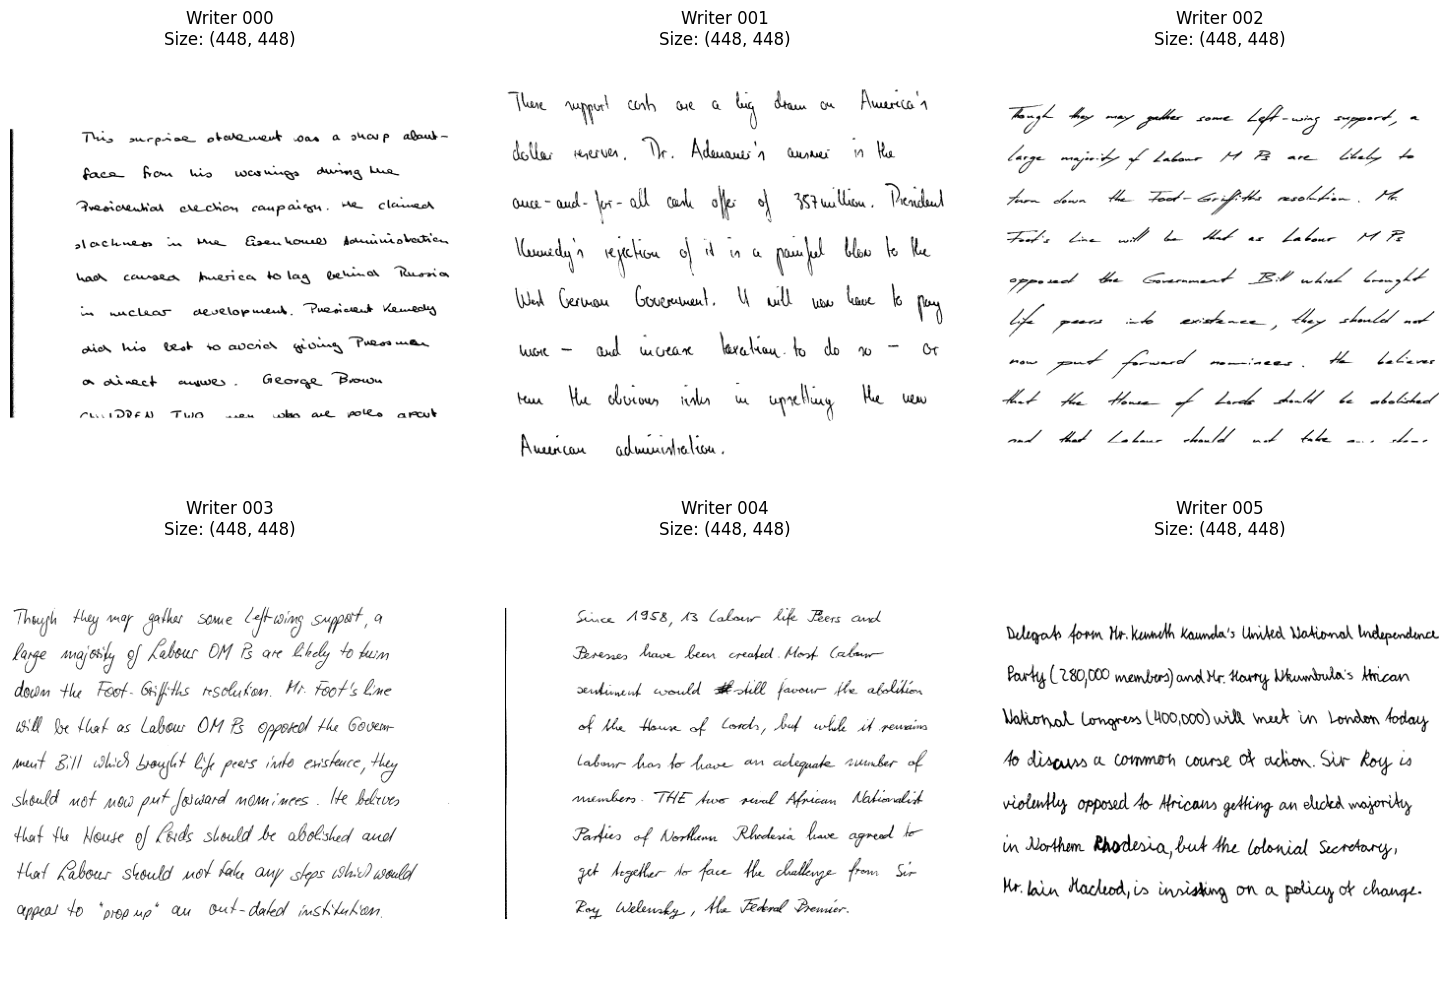


📊 Dataset Statistics:
Total writers: 657
Image size: 448×448
Output folder: dataset/handwritten_processed


In [4]:
# Visualize samples from different writers
sample_folders = sorted(os.listdir(iam_output_folder))[:6]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, folder in enumerate(sample_folders):
    folder_path = os.path.join(iam_output_folder, folder)
    images = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    
    if images:
        sample_img_path = os.path.join(folder_path, images[0])
        img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)
        
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(f'Writer {folder}\nSize: {img.shape}')
        axes[idx].axis('off')

plt.tight_layout()
plt.savefig('preprocessing_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Dataset Statistics:")
print(f"Total writers: {len(os.listdir(iam_output_folder))}")
print(f"Image size: {TARGET_SIZE}×{TARGET_SIZE}")
print(f"Output folder: {iam_output_folder}")

In [5]:
rimes_input_path = "/kaggle/input/handwritten2text-training-dataset/Handwritten2Text Training Dataset/Images"
rimes_output_folder = "dataset/rimes_processed"
os.makedirs(rimes_output_folder, exist_ok=True)

TARGET_SIZE = 448
LINE_HEIGHT = 32  # Altezza fissa per ogni riga
LINES_PER_BATCH = TARGET_SIZE // LINE_HEIGHT  # ~8 righe per batch

In [6]:
def preprocess_single_line(image):
    """Applica threshold + crop"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    binary_inv = 255 - binary
    row_sums = np.sum(binary_inv > 0, axis=1)
    col_sums = np.sum(binary_inv > 0, axis=0)
    
    text_rows = np.where(row_sums > 0)[0]
    text_cols = np.where(col_sums > 0)[0]
    
    if len(text_rows) == 0 or len(text_cols) == 0:
        return None
    
    y1, y2 = text_rows[0], text_rows[-1]
    x1, x2 = text_cols[0], text_cols[-1]
    
    pad = 5
    h, w = binary.shape
    cropped = binary[max(0, y1-pad):min(h, y2+pad), max(0, x1-pad):min(w, x2+pad)]
    
    # Resize a 50px altezza mantenendo aspect ratio
    h, w = cropped.shape
    aspect = LINE_HEIGHT / h
    new_w = int(w * aspect)
    resized = cv2.resize(cropped, (new_w, LINE_HEIGHT), interpolation=cv2.INTER_AREA)
    
    # Porta a 448px larghezza
    if new_w > TARGET_SIZE:
        resized = resized[:, :TARGET_SIZE]
    else:
        canvas = np.full((LINE_HEIGHT, TARGET_SIZE), 255, dtype=np.uint8)
        canvas[:, :new_w] = resized
        resized = canvas
    
    return resized

In [7]:
from collections import defaultdict

# Raggruppa immagini per writer
writer_images = defaultdict(list)

print("📂 Scanning RIMES dataset...")
for img_name in tqdm(sorted(os.listdir(rimes_input_path))):
    if not img_name.endswith(('.jpg', '.png', '.jpeg')):
        continue
    
    parts = img_name.split('-')
    if len(parts) < 2:
        continue
    writer_id = parts[1].split('_')[0]
    
    img_path = os.path.join(rimes_input_path, img_name)
    writer_images[writer_id].append(img_path)

print(f"✅ Found {len(writer_images)} writers\n")

# Processa ogni writer
total_batches = 0
for writer_id, image_paths in tqdm(writer_images.items(), desc="Processing writers"):
    writer_folder = os.path.join(rimes_output_folder, writer_id)
    os.makedirs(writer_folder, exist_ok=True)
    
    # Preprocessa tutte le righe (già 50x448)
    processed_lines = []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        if img is None:
            continue
        line = preprocess_single_line(img)
        if line is not None:
            processed_lines.append(line)
    
    if not processed_lines:
        continue
    
    # Crea batch da 8 righe
    batch_num = 0
    for i in range(0, len(processed_lines), LINES_PER_BATCH):
        batch_lines = processed_lines[i:i + LINES_PER_BATCH]
        
        # Impila e padding
        combined = np.vstack(batch_lines)
        ch = combined.shape[0]
        
        canvas = np.full((TARGET_SIZE, TARGET_SIZE), 255, dtype=np.uint8)
        canvas[:ch, :] = combined
        
        cv2.imwrite(os.path.join(writer_folder, f"batch_{batch_num:03d}.png"), canvas)
        batch_num += 1
        total_batches += 1

print(f"\n🎉 Complete!")
print(f"Writers: {len(writer_images)} | Batches: {total_batches}")
print(f"Lines per batch: {LINES_PER_BATCH} | Output: {rimes_output_folder}")

📂 Scanning RIMES dataset...


100%|██████████| 12111/12111 [00:00<00:00, 554385.29it/s]


✅ Found 1500 writers



Processing writers: 100%|██████████| 1500/1500 [01:54<00:00, 13.10it/s]


🎉 Complete!
Writers: 1500 | Batches: 1571
Lines per batch: 14 | Output: dataset/rimes_processed


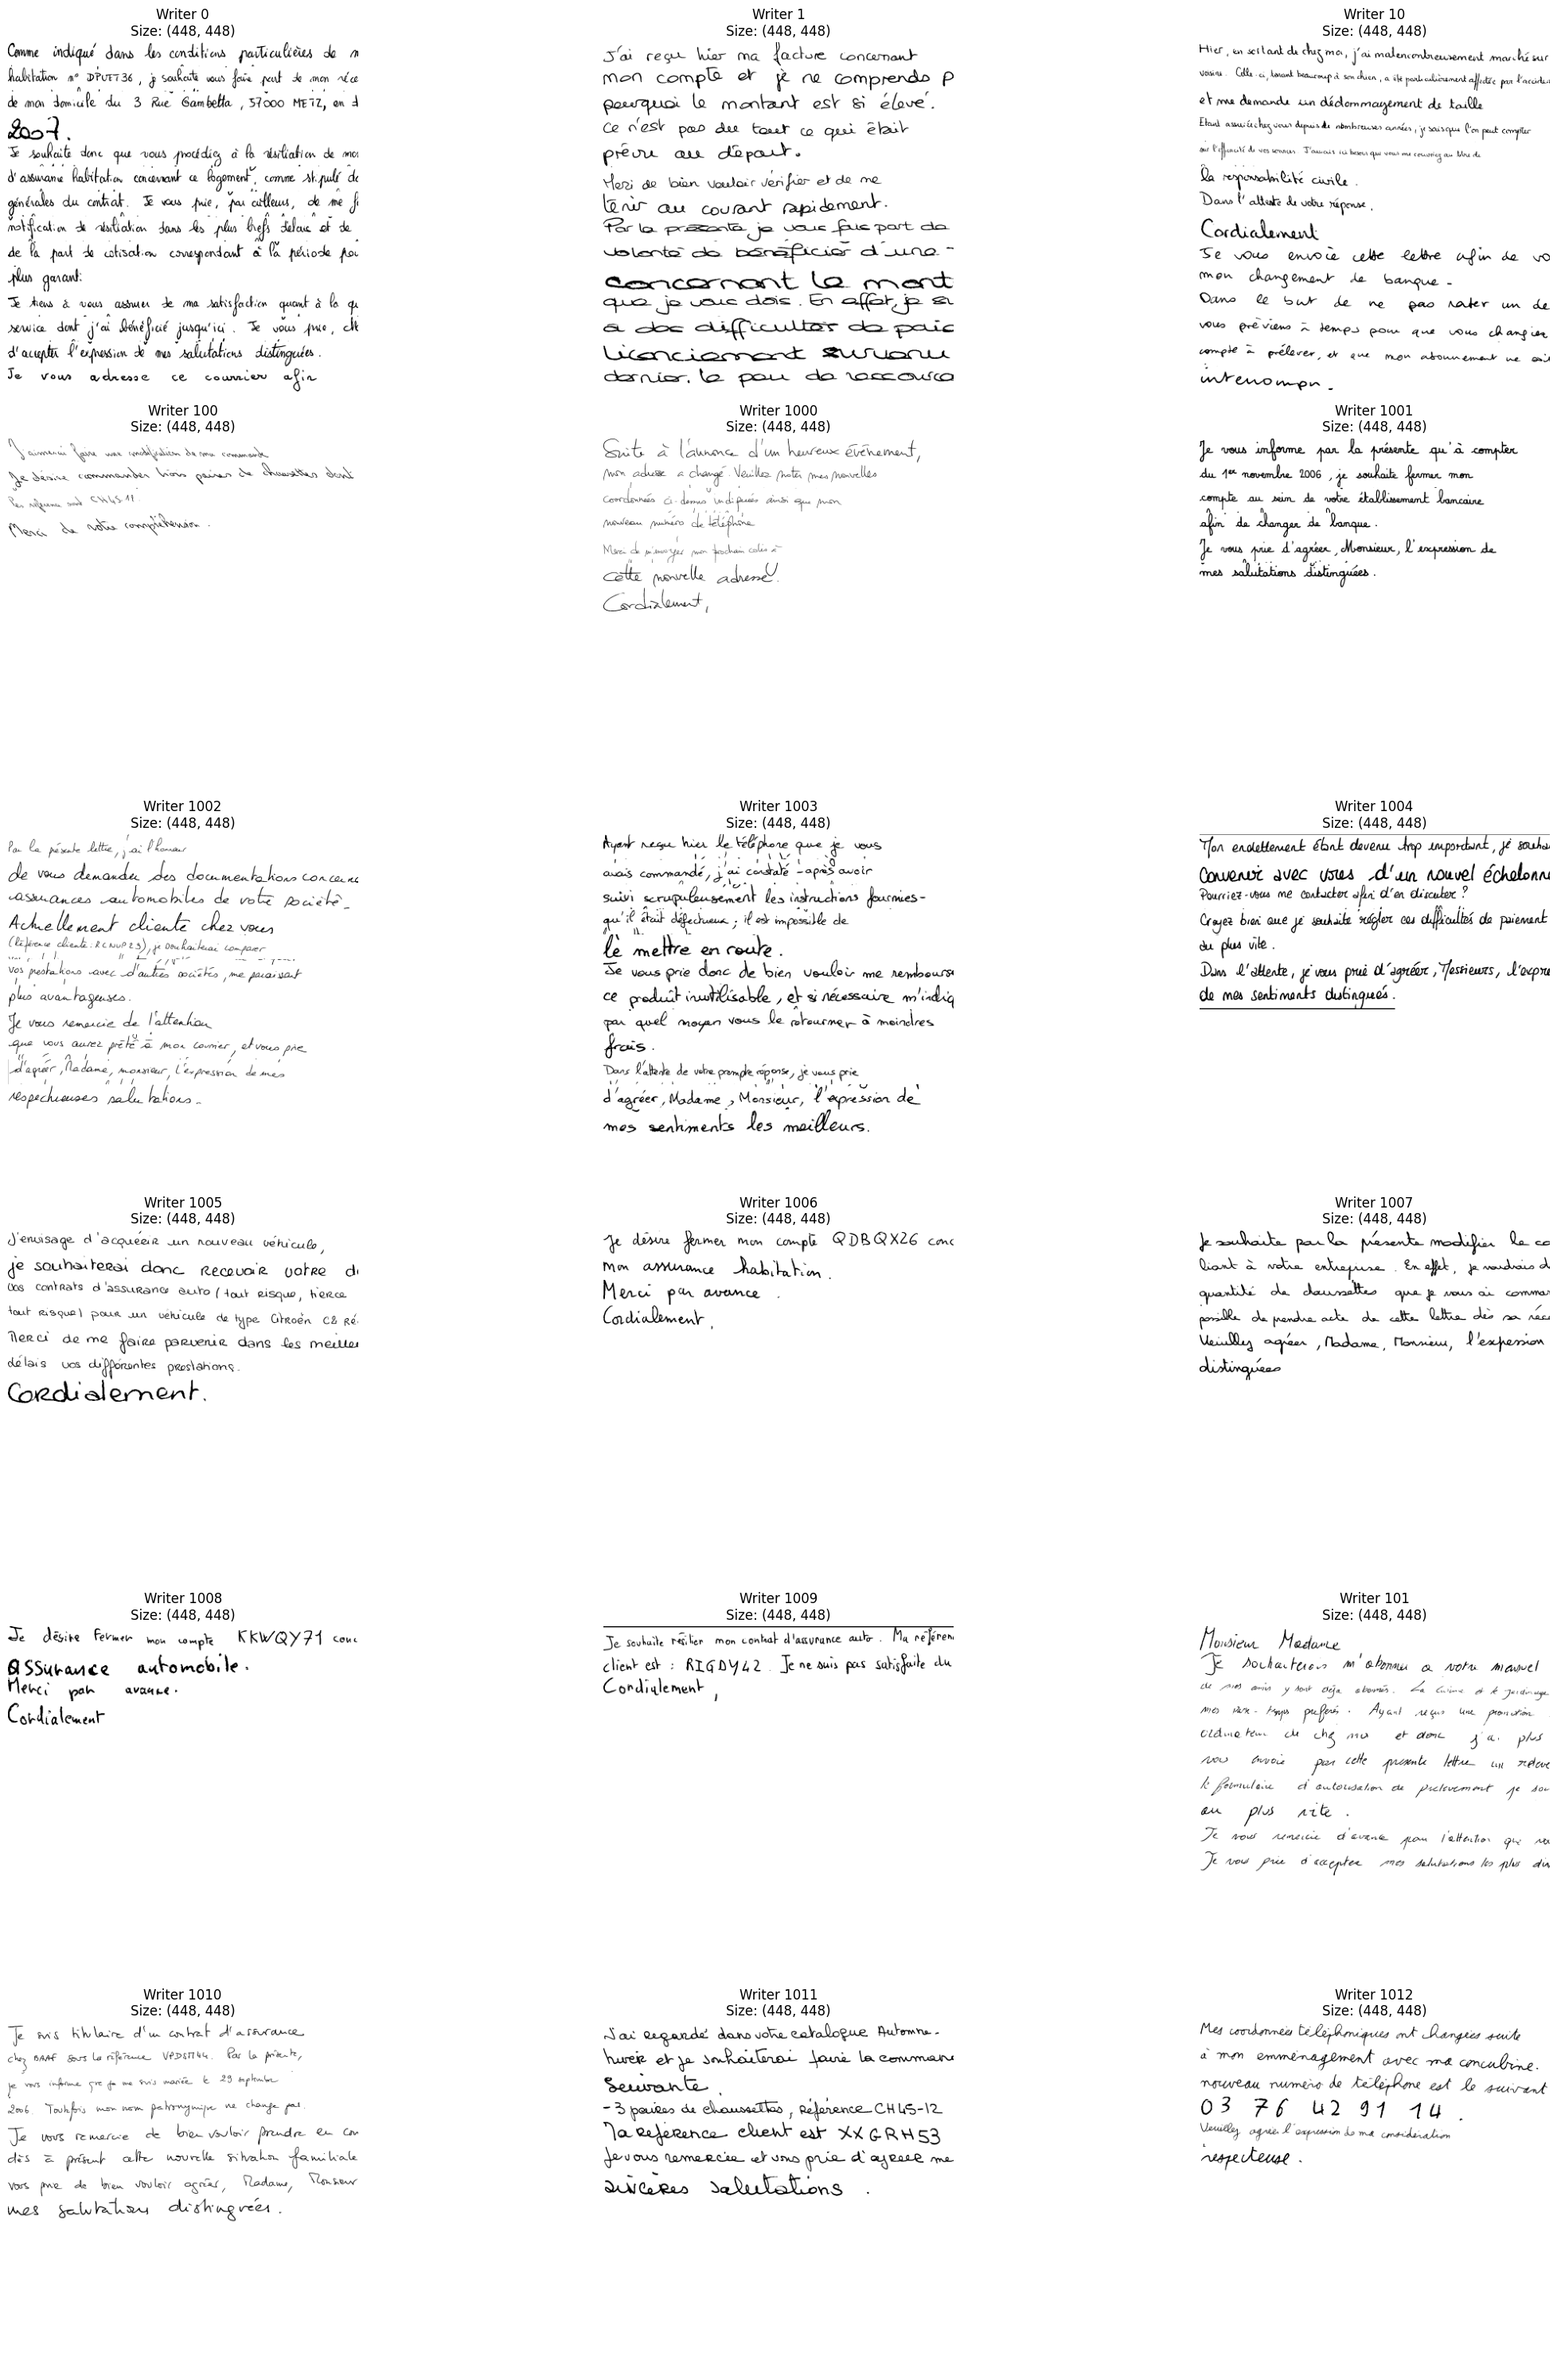


📊 RIMES Dataset Statistics:
Total writers: 1500
Total batches created: 1571
Image size: 448×448
Output folder: dataset/rimes_processed


In [8]:
# Visualize samples from different writers
sample_folders = sorted(os.listdir(rimes_output_folder))[:18]
fig, axes = plt.subplots(6, 3, figsize=(25, 30))
axes = axes.flatten()

for idx, folder in enumerate(sample_folders):
    folder_path = os.path.join(rimes_output_folder, folder)
    images = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    
    if images:
        sample_img_path = os.path.join(folder_path, images[0])
        img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)
        
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(f'Writer {folder}\nSize: {img.shape}')
        axes[idx].axis('off')

plt.tight_layout()
plt.savefig('rimes_preprocessing_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 RIMES Dataset Statistics:")
print(f"Total writers: {len(os.listdir(rimes_output_folder))}")
print(f"Total batches created: {total_batches}")
print(f"Image size: {TARGET_SIZE}×{TARGET_SIZE}")
print(f"Output folder: {rimes_output_folder}")

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import random
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import norm

# ========== CONFIG ==========
TARGET_SIZE = 448
NUM_WORKERS = 4
BATCH_SIZE = 16
EMBEDDING_DIM = 128
MARGIN = 0.5
EPOCHS = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [11]:
# ========== TRIPLET DATASET ==========
class TripletDataset(Dataset):
    def __init__(self, writer_dirs, split='train', triplets_per_writer=100):
        self.writer_dirs = writer_dirs
        self.split = split
        self.triplets_per_writer = triplets_per_writer
        
        if split == 'train':
            self.transform = transforms.Compose([
                transforms.RandomResizedCrop(TARGET_SIZE, scale=(0.9, 1.1)),
                transforms.RandomRotation(10),
                transforms.ToTensor()
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((TARGET_SIZE, TARGET_SIZE)),
                transforms.ToTensor()
            ])
        
        self.writer_images = {}
        for writer_dir in writer_dirs:
            writer_id = Path(writer_dir).name
            images = [os.path.join(writer_dir, f) for f in os.listdir(writer_dir)
                     if f.endswith('.png')]
            if len(images) >= 2:
                self.writer_images[writer_id] = images
        
        self.writer_ids = list(self.writer_images.keys())
        self.num_triplets = len(self.writer_ids) * triplets_per_writer
        
        print(f"{split.upper()}: {len(self.writer_ids)} writers, {self.num_triplets} triplets")
    
    def __len__(self):
        return self.num_triplets
    
    def __getitem__(self, idx):
        anchor_writer = random.choice(self.writer_ids)
        anchor_path, positive_path = random.sample(self.writer_images[anchor_writer], 2)
        
        negative_writer = random.choice([w for w in self.writer_ids if w != anchor_writer])
        negative_path = random.choice(self.writer_images[negative_writer])
        
        anchor = self.transform(Image.open(anchor_path).convert("L"))
        positive = self.transform(Image.open(positive_path).convert("L"))
        negative = self.transform(Image.open(negative_path).convert("L"))
        
        return anchor, positive, negative

In [12]:
# ========== TRIPLET LOSS ==========
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super().__init__()
        self.margin = margin
    
    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive, p=2)
        neg_dist = F.pairwise_distance(anchor, negative, p=2)
        losses = F.relu(pos_dist - neg_dist + self.margin)
        return losses.mean()

In [19]:
# ========== MODEL ==========
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

class TripletNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        mobilenet = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
        mobilenet.features[0][0] = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)
        
        self.encoder = nn.Sequential(
            mobilenet.features,
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(576, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, embedding_dim)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x)
        return F.normalize(x, p=2, dim=1)
    
    def get_embedding(self, x):
        return self.forward(x)

In [20]:
# ========== COMPREHENSIVE BIOMETRIC METRICS ==========
def compute_biometric_metrics(genuine_dists, impostor_dists):
    """
    Compute all biometric metrics for evaluation.
    """
    metrics = {}
    
    # Prepare data for ROC
    y_true = [1] * len(genuine_dists) + [0] * len(impostor_dists)
    y_scores = [-d for d in (genuine_dists + impostor_dists)]  # Lower dist = same writer
    
    # 1. ROC CURVE & AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    thresholds = -thresholds  # Convert back to distances
    metrics['auc'] = auc(fpr, tpr)
    metrics['fpr'] = fpr
    metrics['tpr'] = tpr
    metrics['thresholds'] = thresholds
    
    # 2. EQUAL ERROR RATE (EER)
    fnr = 1 - tpr
    eer_idx = np.argmin(np.abs(fpr - fnr))
    metrics['eer'] = (fpr[eer_idx] + fnr[eer_idx]) / 2
    metrics['eer_threshold'] = thresholds[eer_idx]
    
    # 3. ACCURACY @ FAR = 0.1% and 1%
    for target_far in [0.001, 0.01]:
        idx = np.argmin(np.abs(fpr - target_far))
        actual_far = fpr[idx]
        frr = fnr[idx]
        accuracy = 1 - ((actual_far + frr) / 2)
        threshold = thresholds[idx]
        
        metrics[f'acc_far_{target_far*100:.1f}%'] = accuracy
        metrics[f'frr_far_{target_far*100:.1f}%'] = frr
        metrics[f'threshold_far_{target_far*100:.1f}%'] = threshold
    
    # 4. D-PRIME (d')
    mu_genuine = np.mean(genuine_dists)
    mu_impostor = np.mean(impostor_dists)
    sigma_genuine = np.std(genuine_dists)
    sigma_impostor = np.std(impostor_dists)
    
    pooled_std = np.sqrt((sigma_genuine**2 + sigma_impostor**2) / 2)
    metrics['d_prime'] = (mu_impostor - mu_genuine) / pooled_std if pooled_std > 0 else 0
    
    # 5. DECIDABILITY INDEX
    metrics['decidability'] = metrics['d_prime'] * np.sqrt(2)
    
    # Store distributions
    metrics['genuine_dists'] = genuine_dists
    metrics['impostor_dists'] = impostor_dists
    metrics['mu_genuine'] = mu_genuine
    metrics['mu_impostor'] = mu_impostor
    metrics['sigma_genuine'] = sigma_genuine
    metrics['sigma_impostor'] = sigma_impostor
    
    return metrics

def compute_rank1_identification(model, dataset, num_queries=100):
    """
    Compute Rank-1 Identification Rate.
    For each query, find the most similar writer in the gallery.
    """
    model.eval()
    writer_ids = dataset.writer_ids
    writer_images = dataset.writer_images
    
    # Build gallery: one embedding per writer
    gallery_embeddings = {}
    with torch.no_grad():
        for writer_id in writer_ids:
            img_path = random.choice(writer_images[writer_id])
            img = dataset.transform(Image.open(img_path).convert("L")).unsqueeze(0).to(device)
            emb = model(img).cpu().numpy()[0]
            gallery_embeddings[writer_id] = emb
    
    # Test queries
    correct = 0
    with torch.no_grad():
        for _ in range(num_queries):
            query_writer = random.choice(writer_ids)
            query_img_path = random.choice(writer_images[query_writer])
            query_img = dataset.transform(Image.open(query_img_path).convert("L")).unsqueeze(0).to(device)
            query_emb = model(query_img).cpu().numpy()[0]
            
            # Find closest gallery writer
            min_dist = float('inf')
            predicted_writer = None
            
            for writer_id, gallery_emb in gallery_embeddings.items():
                dist = np.linalg.norm(query_emb - gallery_emb)
                if dist < min_dist:
                    min_dist = dist
                    predicted_writer = writer_id
            
            if predicted_writer == query_writer:
                correct += 1
    
    rank1_rate = correct / num_queries
    return rank1_rate

def evaluate_comprehensive(model, dataset, num_pairs=2000, dataset_name="Test"):
    """
    Full biometric evaluation with all metrics.
    """
    print(f"\n{'='*70}")
    print(f"COMPREHENSIVE EVALUATION: {dataset_name}")
    print(f"{'='*70}\n")
    
    model.eval()
    genuine_dists = []
    impostor_dists = []
    
    writer_ids = dataset.writer_ids
    writer_images = dataset.writer_images
    
    with torch.no_grad():
        # Genuine pairs
        for _ in tqdm(range(num_pairs // 2), desc="Genuine pairs"):
            writer = random.choice(writer_ids)
            if len(writer_images[writer]) < 2:
                continue
            
            img1_path, img2_path = random.sample(writer_images[writer], 2)
            img1 = dataset.transform(Image.open(img1_path).convert("L")).unsqueeze(0).to(device)
            img2 = dataset.transform(Image.open(img2_path).convert("L")).unsqueeze(0).to(device)
            
            emb1 = model(img1)
            emb2 = model(img2)
            dist = F.pairwise_distance(emb1, emb2).item()
            genuine_dists.append(dist)
        
        # Impostor pairs
        for _ in tqdm(range(num_pairs // 2), desc="Impostor pairs"):
            w1, w2 = random.sample(writer_ids, 2)
            img1_path = random.choice(writer_images[w1])
            img2_path = random.choice(writer_images[w2])
            
            img1 = dataset.transform(Image.open(img1_path).convert("L")).unsqueeze(0).to(device)
            img2 = dataset.transform(Image.open(img2_path).convert("L")).unsqueeze(0).to(device)
            
            emb1 = model(img1)
            emb2 = model(img2)
            dist = F.pairwise_distance(emb1, emb2).item()
            impostor_dists.append(dist)
    
    # Compute all metrics
    metrics = compute_biometric_metrics(genuine_dists, impostor_dists)
    
    # Rank-1 identification (if enough writers)
    if len(writer_ids) >= 10:
        rank1 = compute_rank1_identification(model, dataset, num_queries=min(100, len(writer_ids)*5))
        metrics['rank1_identification'] = rank1
    else:
        metrics['rank1_identification'] = None
    
    # Print results
    print(f"\n📊 PRIMARY METRICS:")
    print(f"  EER (Equal Error Rate):     {metrics['eer']:.4f} ({metrics['eer']*100:.2f}%)")
    print(f"  AUC-ROC:                     {metrics['auc']:.4f}")
    print(f"  Accuracy @ FAR=0.1%:         {metrics['acc_far_0.1%']:.4f}")
    print(f"  Accuracy @ FAR=1.0%:         {metrics['acc_far_1.0%']:.4f}")
    
    print(f"\n📈 SECONDARY METRICS:")
    print(f"  d-prime (d'):                {metrics['d_prime']:.4f}")
    print(f"  Decidability Index:          {metrics['decidability']:.4f}")
    if metrics['rank1_identification'] is not None:
        print(f"  Rank-1 Identification Rate:  {metrics['rank1_identification']:.4f} ({metrics['rank1_identification']*100:.2f}%)")
    
    print(f"\n📏 DISTANCE STATISTICS:")
    print(f"  Genuine:  μ={metrics['mu_genuine']:.4f}, σ={metrics['sigma_genuine']:.4f}")
    print(f"  Impostor: μ={metrics['mu_impostor']:.4f}, σ={metrics['sigma_impostor']:.4f}")
    
    print(f"\n🎯 OPERATING POINTS:")
    print(f"  EER Threshold:          {metrics['eer_threshold']:.4f}")
    print(f"  Threshold @ FAR=0.1%:   {metrics['threshold_far_0.1%']:.4f} (FRR={metrics['frr_far_0.1%']*100:.2f}%)")
    print(f"  Threshold @ FAR=1.0%:   {metrics['threshold_far_1.0%']:.4f} (FRR={metrics['frr_far_1.0%']*100:.2f}%)")
    
    return metrics

def plot_comprehensive_results(metrics, save_prefix="results/test"):
    """
    Create comprehensive visualization of all metrics.
    """
    fig = plt.figure(figsize=(16, 12))
    
    # 1. ROC CURVE with operating points
    ax1 = plt.subplot(2, 3, 1)
    ax1.plot(metrics['fpr'], metrics['tpr'], 'darkorange', lw=2, label=f'AUC={metrics["auc"]:.4f}')
    ax1.plot([0, 1], [0, 1], 'navy', lw=2, linestyle='--', label='Random')
    
    # Mark EER point
    eer_idx = np.argmin(np.abs(metrics['fpr'] - (1 - metrics['tpr'])))
    ax1.scatter(metrics['fpr'][eer_idx], metrics['tpr'][eer_idx], color='red', s=100, 
                zorder=5, label=f'EER={metrics["eer"]:.4f}')
    
    # Mark FAR operating points
    for far_target in [0.001, 0.01]:
        idx = np.argmin(np.abs(metrics['fpr'] - far_target))
        ax1.scatter(metrics['fpr'][idx], metrics['tpr'][idx], s=80, zorder=5,
                   label=f'FAR={far_target*100:.1f}%')
    
    ax1.set_xlabel('False Accept Rate (FAR)')
    ax1.set_ylabel('True Accept Rate (TAR)')
    ax1.set_title('ROC Curve with Operating Points')
    ax1.legend(loc='lower right', fontsize=9)
    ax1.grid(alpha=0.3)
    
    # 2. Distance distributions
    ax2 = plt.subplot(2, 3, 2)
    ax2.hist(metrics['genuine_dists'], bins=50, alpha=0.6, label='Genuine', color='green', density=True)
    ax2.hist(metrics['impostor_dists'], bins=50, alpha=0.6, label='Impostor', color='red', density=True)
    ax2.axvline(metrics['eer_threshold'], color='black', linestyle='--', 
                label=f'EER Threshold', linewidth=2)
    ax2.set_xlabel('Euclidean Distance')
    ax2.set_ylabel('Density')
    ax2.set_title('Distance Distributions')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # 3. FAR vs FRR curves
    ax3 = plt.subplot(2, 3, 3)
    frr = 1 - metrics['tpr']
    ax3.plot(metrics['thresholds'], metrics['fpr'], label='FAR', color='red', lw=2)
    ax3.plot(metrics['thresholds'], frr, label='FRR', color='blue', lw=2)
    ax3.axvline(metrics['eer_threshold'], color='black', linestyle='--', 
                label=f'EER Point', linewidth=2)
    ax3.set_xlabel('Threshold (Distance)')
    ax3.set_ylabel('Error Rate')
    ax3.set_title('FAR vs FRR')
    ax3.set_yscale('log')
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    # 4. Gaussian fits (if distributions are roughly normal)
    ax4 = plt.subplot(2, 3, 4)
    x = np.linspace(0, max(max(metrics['genuine_dists']), max(metrics['impostor_dists'])), 200)
    
    genuine_pdf = norm.pdf(x, metrics['mu_genuine'], metrics['sigma_genuine'])
    impostor_pdf = norm.pdf(x, metrics['mu_impostor'], metrics['sigma_impostor'])
    
    ax4.plot(x, genuine_pdf, 'g-', lw=2, label='Genuine (fitted)')
    ax4.plot(x, impostor_pdf, 'r-', lw=2, label='Impostor (fitted)')
    ax4.fill_between(x, 0, genuine_pdf, alpha=0.3, color='green')
    ax4.fill_between(x, 0, impostor_pdf, alpha=0.3, color='red')
    ax4.set_xlabel('Distance')
    ax4.set_ylabel('Probability Density')
    ax4.set_title(f'Gaussian Fits (d\'={metrics["d_prime"]:.2f})')
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    # 5. Detection Error Tradeoff (DET) curve
    ax5 = plt.subplot(2, 3, 5)
    ax5.plot(metrics['fpr'] * 100, frr * 100, 'b-', lw=2)
    ax5.scatter(metrics['fpr'][eer_idx] * 100, frr[eer_idx] * 100, 
                color='red', s=100, zorder=5, label=f'EER={metrics["eer"]*100:.2f}%')
    ax5.set_xlabel('False Accept Rate (%)')
    ax5.set_ylabel('False Reject Rate (%)')
    ax5.set_title('Detection Error Tradeoff (DET)')
    ax5.set_xscale('log')
    ax5.set_yscale('log')
    ax5.legend()
    ax5.grid(alpha=0.3, which='both')
    
    # 6. Metrics summary table
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    summary_data = [
        ['Metric', 'Value'],
        ['EER', f'{metrics["eer"]:.4f} ({metrics["eer"]*100:.2f}%)'],
        ['AUC-ROC', f'{metrics["auc"]:.4f}'],
        ['Acc @ FAR=0.1%', f'{metrics["acc_far_0.1%"]:.4f}'],
        ['Acc @ FAR=1.0%', f'{metrics["acc_far_1.0%"]:.4f}'],
        ['d-prime', f'{metrics["d_prime"]:.4f}'],
        ['Decidability', f'{metrics["decidability"]:.4f}'],
    ]
    
    if metrics['rank1_identification'] is not None:
        summary_data.append(['Rank-1 ID Rate', f'{metrics["rank1_identification"]:.4f}'])
    
    table = ax6.table(cellText=summary_data, cellLoc='left', loc='center',
                     colWidths=[0.6, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Style header
    for i in range(2):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax6.set_title('Metrics Summary', fontweight='bold', fontsize=12, pad=20)
    
    plt.tight_layout()
    plt.savefig(f'{save_prefix}_comprehensive.png', dpi=300, bbox_inches='tight')
    plt.show()

Total writers: 657

Writer Split:
  Train: 459 (70%)
  Val:   99 (15%)
  Test:  99 (15%)

TRAIN: 218 writers, 21800 triplets
VAL: 43 writers, 4300 triplets
TEST: 40 writers, 4000 triplets


In [21]:
# ========== TRAINING ==========
def train_model(model, train_loader, val_dataset, epochs, save_prefix):
    criterion = TripletLoss(margin=MARGIN)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    history = {'epoch': [], 'train_loss': [], 'val_eer': [], 'val_auc': []}
    
    best_eer = float('inf')
    patience_counter = 0
    patience = 7
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for anchor, positive, negative in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            
            optimizer.zero_grad()
            anchor_emb = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)
            
            loss = criterion(anchor_emb, positive_emb, negative_emb)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Quick validation (just EER/AUC)
        val_metrics = evaluate_comprehensive(model, val_dataset, num_pairs=1000, 
                                            dataset_name=f"Validation Epoch {epoch+1}")
        
        scheduler.step(val_metrics['eer'])
        
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(train_loss)
        history['val_eer'].append(val_metrics['eer'])
        history['val_auc'].append(val_metrics['auc'])
        
        if val_metrics['eer'] < best_eer:
            best_eer = val_metrics['eer']
            patience_counter = 0
            torch.save(model.state_dict(), f"{save_prefix}_best.pth")
            print(f"  ✓ Saved best model (EER: {best_eer:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("\n⚠ Early stopping")
                break
    
    torch.save(model.state_dict(), f"{save_prefix}_final.pth")
    pd.DataFrame(history).to_csv(f"{save_prefix}_history.csv", index=False)
    return history

In [22]:
# ========== TRAINING ==========
def train_model(model, train_loader, val_dataset, epochs=50):
    os.makedirs("results", exist_ok=True)
    
    criterion = TripletLoss(margin=MARGIN)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    history = {
        'epoch': [], 'train_loss': [], 'val_eer': [], 'val_auc': []
    }
    
    best_eer = float('inf')
    patience_counter = 0
    patience = 7
    
    for epoch in range(epochs):
        # ===== TRAINING =====
        model.train()
        train_loss = 0.0
        
        for anchor, positive, negative in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            
            optimizer.zero_grad()
            
            # Get embeddings
            anchor_emb = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)
            
            loss = criterion(anchor_emb, positive_emb, negative_emb)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # ===== VALIDATION =====
        val_metrics = evaluate_embeddings(model, val_dataset, num_pairs=1000)
        
        scheduler.step(val_metrics['eer'])
        
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(train_loss)
        history['val_eer'].append(val_metrics['eer'])
        history['val_auc'].append(val_metrics['auc'])
        
        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val EER: {val_metrics['eer']:.4f} | AUC: {val_metrics['auc']:.4f}")
        
        # ===== EARLY STOPPING =====
        if val_metrics['eer'] < best_eer:
            best_eer = val_metrics['eer']
            patience_counter = 0
            torch.save(model.state_dict(), "results/triplet_best.pth")
            print(f"  ✓ Saved best model (EER: {best_eer:.4f})")
        else:
            patience_counter += 1
            print(f"  Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("\n⚠ Early stopping triggered.")
                break
    
    torch.save(model.state_dict(), "results/triplet_final.pth")
    pd.DataFrame(history).to_csv("results/triplet_history.csv", index=False)
    
    return history

In [24]:
os.makedirs("results", exist_ok=True)
    
    # Load datasets
    iam_root = "dataset/handwritten_processed"
    rimes_root = "dataset/rimes_processed"
    
    iam_dirs = [os.path.join(iam_root, d) for d in sorted(os.listdir(iam_root))
                if os.path.isdir(os.path.join(iam_root, d))]
    rimes_dirs = [os.path.join(rimes_root, d) for d in sorted(os.listdir(rimes_root))
                  if os.path.isdir(os.path.join(rimes_root, d))]
    
    print(f"IAM writers: {len(iam_dirs)}")
    print(f"RIMES writers: {len(rimes_dirs)}")
    
    # Split IAM
    iam_train, iam_temp = train_test_split(iam_dirs, test_size=0.2, random_state=42)
    iam_val, iam_test = train_test_split(iam_temp, test_size=0.5, random_state=42)
    
    # Split RIMES
    rimes_train, rimes_temp = train_test_split(rimes_dirs, test_size=0.2, random_state=42)
    rimes_val, rimes_test = train_test_split(rimes_temp, test_size=0.5, random_state=42)
    
    print(f"\nIAM: Train={len(iam_train)}, Val={len(iam_val)}, Test={len(iam_test)}")
    print(f"RIMES: Train={len(rimes_train)}, Val={len(rimes_val)}, Test={len(rimes_test)}")
    
    results_summary = []
    
    # ===== EXPERIMENT 1: Train IAM → Test IAM =====
    print("\n" + "="*70)
    print("EXPERIMENT 1: Train IAM → Test IAM")
    print("="*70)
    
    train_ds = TripletDataset(iam_train, 'train', 100)
    val_ds = TripletDataset(iam_val, 'val', 100)
    test_ds = TripletDataset(iam_test, 'test', 100)
    
    train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    
    model = TripletNet(EMBEDDING_DIM).to(device)
    train_model(model, train_loader, val_ds, EPOCHS, "results/iam_to_iam")
    
    model.load_state_dict(torch.load("results/iam_to_iam_best.pth"))
    metrics = evaluate_comprehensive(model, test_ds, 2000, "IAM→IAM Test")
    plot_comprehensive_results(metrics, "results/iam_to_iam")
    results_summary.append({'experiment': 'IAM→IAM', **{k: v for k, v in metrics.items() 
                                                         if not isinstance(v, (list, np.ndarray))}})
    
    # ===== EXPERIMENT 2: Train IAM → Test RIMES =====
    print("\n" + "="*70)
    print("EXPERIMENT 2: Train IAM → Test RIMES (Cross-Dataset)")
    print("="*70)
    
    test_ds_rimes = TripletDataset(rimes_test, 'test', 100)
    metrics = evaluate_comprehensive(model, test_ds_rimes, 2000, "IAM→RIMES Test")
    plot_comprehensive_results(metrics, "results/iam_to_rimes")
    results_summary.append({'experiment': 'IAM→RIMES', **{k: v for k, v in metrics.items() 
                                                           if not isinstance(v, (list, np.ndarray))}})
    
    # ===== EXPERIMENT 3: Train RIMES → Test RIMES =====
    print("\n" + "="*70)
    print("EXPERIMENT 3: Train RIMES → Test RIMES")
    print("="*70)
    
    train_ds = TripletDataset(rimes_train, 'train', 100)
    val_ds = TripletDataset(rimes_val, 'val', 100)
    test_ds = TripletDataset(rimes_test, 'test', 100)
    
    train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    
    model = TripletNet(EMBEDDING_DIM).to(device)
    train_model(model, train_loader, val_ds, EPOCHS, "results/rimes_to_rimes")
    
    model.load_state_dict(torch.load("results/rimes_to_rimes_best.pth"))
    metrics = evaluate_comprehensive(model, test_ds, 2000, "RIMES→RIMES Test")
    plot_comprehensive_results(metrics, "results/rimes_to_rimes")
    results_summary.append({'experiment': 'RIMES→RIMES', **{k: v for k, v in metrics.items() 
                                                             if not isinstance(v, (list, np.ndarray))}})
    
    # ===== EXPERIMENT 4: Train RIMES → Test IAM =====
    print("\n" + "="*70)
    print("EXPERIMENT 4: Train RIMES → Test IAM (Cross-Dataset)")
    print("="*70)
    
    test_ds_iam = TripletDataset(iam_test, 'test', 100)
    metrics = evaluate_comprehensive(model, test_ds_iam, 2000, "RIMES→IAM Test")
    plot_comprehensive_results(metrics, "results/rimes_to_iam")
    results_summary.append({'experiment': 'RIMES→IAM', **{k: v for k, v in metrics.items() 
                                                           if not isinstance(v, (list, np.ndarray))}})
    
    # ===== FINAL SUMMARY TABLE =====
    df_summary = pd.DataFrame(results_summary)
    df_summary.to_csv("results/experiments_summary.csv", index=False)
    
    print("\n" + "="*70)
    print("FINAL RESULTS SUMMARY")
    print("="*70)
    print(df_summary[['experiment', 'eer', 'auc', 'acc_far_0.1%', 'acc_far_1.0%', 'd_prime']].to_string(index=False))
    print("\n✓ All results saved to results/")